<a href="https://colab.research.google.com/github/byu-cce270/content/blob/main/homework/hw1_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Instructions:**
*This is a Google Colab Notebook, shared via Github. You may perform operations within this notebook and download your files once you're done. Your changes will not be saved if you refresh this page. You can save a copy of this notebook by clicking on the File tab, then save a copy.*

* **To run each cell, press the play button on the left. Occasionally, the cell will require additional input after pressing the play button.**
* If an error appears, double check that all input options are correct.

For more detailed documentation, please visit https://ggst.readthedocs.io

## Install Packages and Select your Tethys Portal

In [ ]:
#@markdown ### **Run this cell to install dependencies**
#@markdown Be patient, this cell may take a few moments to load
# Install dependencies
%%capture
!pip install xarray
!pip install geopandas
!pip install basemap
!pip install netCDF4

In [ ]:
#@markdown ### **Run this cell to load necessary packages**
# Load packages
%%capture
import requests
import os
from zipfile import ZipFile
from io import BytesIO, StringIO
import xarray
import json
import numpy
import pandas
from google.colab import files
import ipywidgets as widgets
import sys
import matplotlib.pyplot as plt
from netCDF4 import Dataset as NetCDFFile
from PIL import Image
import glob
from os import path
from mpl_toolkits.basemap import Basemap
import shutil

In [ ]:
#@markdown ### **Run this cell to declare the portal**
#@markdown Select your preferred portal from the list or type in your own
portal = "https://tethys.byu.edu" #@param ["https://tethys.byu.edu","https://tethys-staging.byu.edu" ,"https://tethyswa.servirglobal.net"] {allow-input: true}
# use  https://tethyswa.servirglobal.net tethyswa.servirglobal.net for the Portal hosted by the SERVIR WA
# use https://tethys-staging.byu.edu for the Portal hosted by BYU staging
# use https://tethys.byu.edu for the Portal hosted by BYU. We encourage to use any portal but staging.

## Function 1: getStorageOptions

In [ ]:
#@markdown ### **Run this cell to view storage options**
# View available storage types
storage_options = requests.get(portal+ "/apps/ggst/api/getStorageOptions/")
storage_options.json()

{'storage_options': [['Total Water Storage (GRACE)', 'grace'],
  ['Surface Water Storage (GLDAS)', 'sw'],
  ['Soil Moisture Storage (GLDAS)', 'sm'],
  ['Groundwater Storage (Calculated)', 'gw'],
  ['Surface Water Storage (GLDAS NOAH .25)', '025sw'],
  ['Soil Moisture Storage (GLDAS NOAH .25)', '025sm'],
  ['Groundwater Storage (Calculated NOAH .25)', '025gw']]}

## Function 2: getPointValues

In [ ]:
#@markdown ### **Set desired inputs for getPointValues function and run this cell**
Latitude =  31.2483#@param {type:"number"}
Lat = str(Latitude)
Longitude = 34.6762 #@param {type:"number"}
Lon = str(Longitude)
F2_Storage_Option = "gw" #@param ["gw", "sm", "sw", "swe", "tws", "canopy", "grace"]

#Run getPointValues function with your inputs
pointvalues = requests.get(portal + "/apps/ggst/api/getPointValues/?latitude="+Lat+"&longitude="+Lon+"&storage_type="+F2_Storage_Option)

In [ ]:
#@markdown ### **Run this cell to convert the request to a dataframe and view the timeseries table**
# Get the json object from the request
pointvalues_json = pointvalues.json()
# Create a dataframe from the JSON for plotting
point_ts = (pandas.DataFrame(columns=["date", "ts"], data=pointvalues_json["values"])
            .merge(pandas.DataFrame(columns=["date", "error_min", "error_max"], data=pointvalues_json["error_range"]), on="date"))
point_ts["date"] =  pandas.to_datetime(point_ts.date*1000000)
point_ts

,date,ts,error_min,error_max
0,2002-04-01,-4.825,-9.464,-0.185
1,2002-05-01,-3.822,-7.224,-0.421
2,2002-08-01,-1.035,-4.130,2.060
3,2002-09-01,0.078,-3.487,3.644
4,2002-10-01,-0.391,-2.947,2.164
...,...,...,...,...
198,2021-09-01,11.754,10.069,13.439
199,2021-10-01,10.758,9.006,12.510
200,2021-11-01,9.232,6.873,11.590
201,2021-12-01,6.745,3.749,9.742


Text(0.5, 1.0, 'gw Anomaly Timeseries at Point 31.2483, 34.6762')

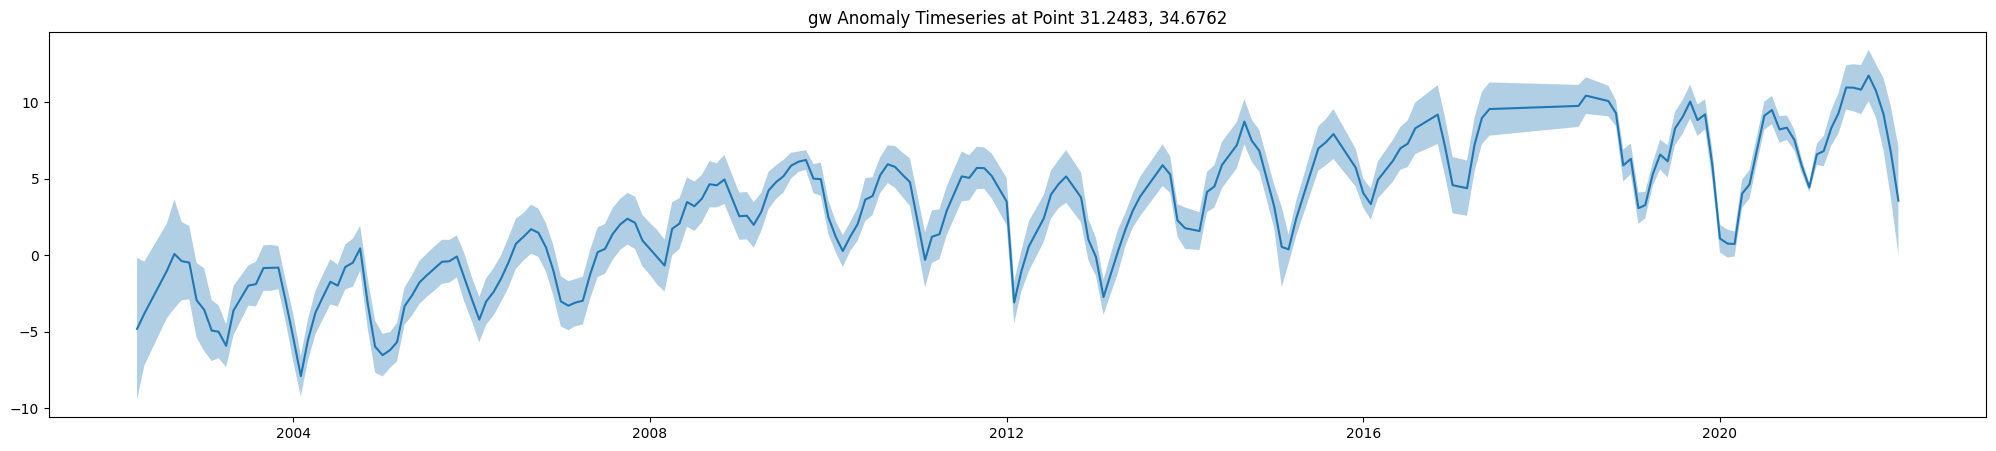

In [ ]:
#@markdown ### **Run this cell to plot the dataframe**
# Plot the dataframe with error range
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(point_ts.date, point_ts.ts)
ax.fill_between(point_ts.date, point_ts.error_min, point_ts.error_max, alpha=0.35)
ax.set_title(F2_Storage_Option+' Anomaly Timeseries at Point ' +Lat+', '+Lon)

In [ ]:
#@markdown ### **Run this cell to create timeseries CSV**
#@markdown  You can download the CSV from the files panel on the left side of the window
#Export timeseries to CSV
point_ts.to_csv('PointTimeseries_'+Lat+'_'+Lon+".csv", index=False)

## Requesting Info for Regional Functions 3 and 4


In [ ]:
#@markdown ###**Input api token in the quotations below and run cell**
# Get API Token from User Settings on the Tethys Portal.
# Note: You have to be logged in to access User Settings
#@markdown Make sure your API token is generated from the same portal you declared at the beginning of this notebook. *A token registered under a different portal will result in errors*.
api_token = "ca8a2995fff94d016bd0257579e0d1ff0cf841ba" #@param {type:"string"}

In [ ]:
#@markdown ###**Input region name then run cell and follow prompts**
#@markdown Select a region name, it must be python friendly so no spaces please.
region_name = "jordan" #@param {type:"string"}

#@markdown After you hit run, this cell will prompt you to upload a file below. This file must be a zipfile contain all four parts of a shapefile (shp, shx, dbf, and prj).
#upload zipped shapefile
uploaded = files.upload()
#set up files for API request
region_files = {'shapefile': ("response.zip", uploaded["".join(uploaded)],'application/zip')}

Saving jordan.zip to jordan.zip


## Function 3: getRegionTimeseries

In [ ]:
#@markdown ### **Set inputs for getRegionTimeseries then run the cell to run the function**
F3_Storage_Option = "gw" #@param ["gw", "sm", "sw", "swe", "tws", "canopy", "grace"]
# Initialize timeseries request. API Token is passed in the headers for authorization.
# Name and Storage Type parameters are passed in the data dictionary object
storage_type = F3_Storage_Option
data_obj = {"name": region_name,
            "storage_type": storage_type}
region_timeseries_request = requests.post(portal + "/apps/ggst/api/getRegionTimeseries/",
                                          headers={"Authorization": f"Token {api_token}"},
                                          data = data_obj,
                                          files= region_files)

In [ ]:
#@markdown ### **Run this cell to convert the request to a dataframe view the timeseries table**

# Get the json object from the request
region_ts_json = region_timeseries_request.json()
# Create a dataframe from the JSON for plotting
region_ts = (pandas.DataFrame(columns=["date", "ts"], data=region_ts_json["values"])
            .merge(pandas.DataFrame(columns=["date", "error_min", "error_max"], data=region_ts_json["error_range"]), on="date"))
region_ts["date"] =  pandas.to_datetime(region_ts.date)
region_ts


,date,ts,error_min,error_max
0,2002-04-01,1.072,-3.635,5.778
1,2002-05-01,1.295,-2.174,4.763
2,2002-08-01,2.535,-0.447,5.516
3,2002-09-01,2.119,-1.843,6.081
4,2002-10-01,2.316,-0.185,4.817
...,...,...,...,...
198,2021-09-01,-13.131,-14.608,-11.654
199,2021-10-01,-13.508,-15.022,-11.994
200,2021-11-01,-12.411,-14.053,-10.769
201,2021-12-01,-12.816,-14.581,-11.050


Text(0.5, 1.0, 'jordan Average gw Storage Anomaly')

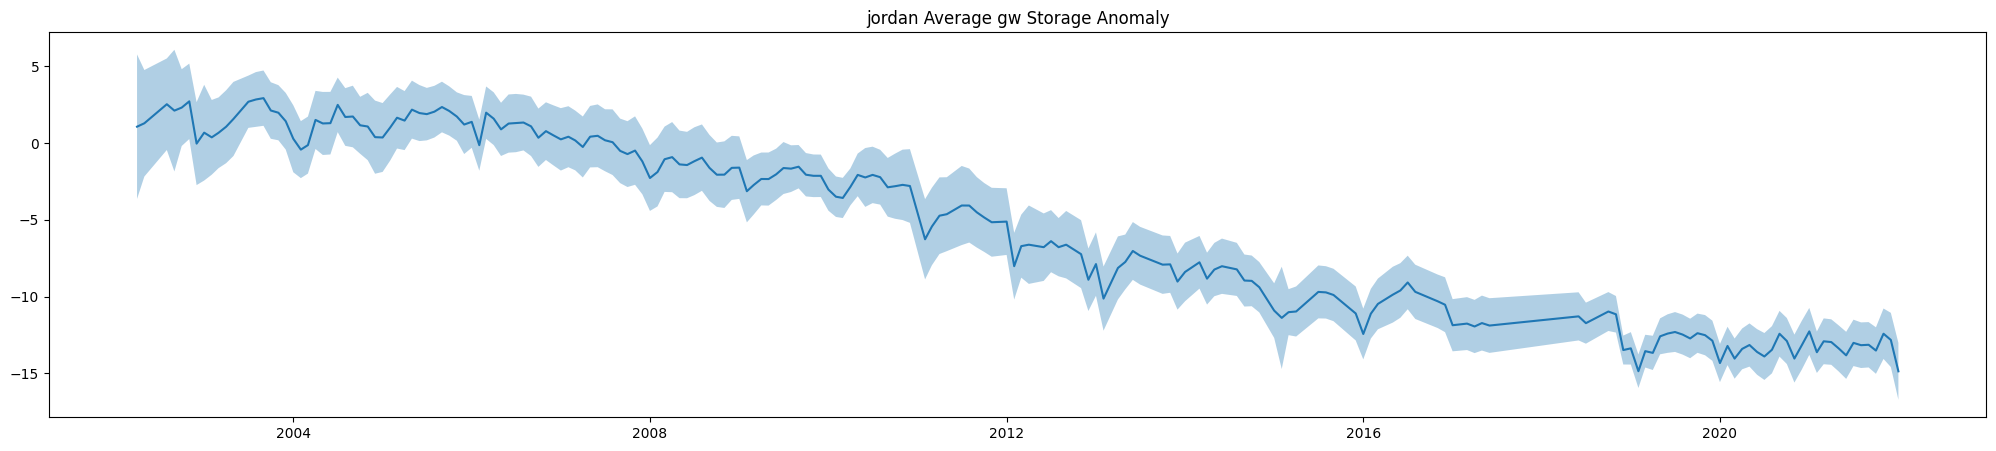

In [ ]:
#@markdown ### **Plot the dataframe with error range**
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(region_ts.date, region_ts.ts)
ax.fill_between(region_ts.date, region_ts.error_min, region_ts.error_max, alpha=0.35)
ax.set_title(region_name + ' Average ' + F3_Storage_Option +' Storage Anomaly')

In [ ]:
#@markdown ### **Run this cell to create timeseries CSV**
#@markdown  You can download the CSV from the files panel on the left side of the window
#Export timeseries to CSV
region_ts.to_csv('RegionTimeseries_'+region_name+".csv", index=False)

## Function 4: getRegionZipfile

In [ ]:
#@markdown ### **Run this cell to read the zipfile and extract its content**
# Declare region name
data_obj = {"name": region_name}
subset_region_request = requests.post(portal + "/apps/ggst/api/subsetRegionZipfile/",
                                      headers={"Authorization": f"Token {api_token}"},
                                      data = data_obj, files=region_files)
#Save the request response and extract the files
z = ZipFile(BytesIO(subset_region_request.content))
z.extractall()

### Plotting RegionZipfile

In [ ]:
#@markdown ### **Run this cell to initiate a function for processing raw data**
# Helper function to calculate regional timeseries for raw data
def get_regional_ts(region, storage_type, grace_dir):
    graph_json = {}
    ts_plot = []
    ts_plot_int = []
    error_range = []
    nc_file = os.path.join(grace_dir, f"{region}_{storage_type}.nc")
    ds = xarray.open_dataset(nc_file)
    region_area = json.load(open(os.path.join(grace_dir, "area.json"), "r"))[
        "area"
    ]
    lwe_da = ds.lwe_thickness.mean(["lat", "lon"])
    error_da = ds.uncertainty.mean(["lat", "lon"])

    init_value = lwe_da.values[0]
    for x, y in zip(lwe_da, error_da):
        value = x.values
        error_bar = y.values
        utc_time = x.time.values
        difference_data_value = (value - init_value) * 0.00000075 * region_area
        ts_plot.append([utc_time, round(float(value), 3)])
        error_range.append(
            [
                utc_time,
                round(float(value - error_bar), 3),
                round(float(value + error_bar), 3),
            ]
        )
        ts_plot_int.append([utc_time, round(float(difference_data_value), 3)])

    graph_json["values"] = ts_plot
    graph_json["depletion_values"] = ts_plot_int
    graph_json["error_range"] = error_range
    graph_json["area"] = region_area
    df = (pandas.DataFrame(ts_plot, columns=["time", "value"])
          .merge(pandas.DataFrame(ts_plot_int, columns=["time", "depletion"]))
          .merge(pandas.DataFrame(error_range, columns=["time", "min_bar", "max_bar"])))
    df["time"] = pandas.to_datetime(df["time"])
    return graph_json, df

In [ ]:
#@markdown ### **Select which storage option you wish to plot and run cell to get Timeseries**

F4_Storage_Option = "gw" #@param ["gw", "sm", "sw", "swe", "tws", "canopy", "grace"]
gw_json, gw_df = get_regional_ts(region_name, F4_Storage_Option, region_name)
gw_df

,time,value,depletion,min_bar,max_bar
0,2002-04-01,1.072,0.000,-3.635,5.778
1,2002-05-01,1.295,14808.776,-2.174,4.763
2,2002-08-01,2.535,97116.651,-0.447,5.516
3,2002-09-01,2.119,69548.215,-1.843,6.081
4,2002-10-01,2.316,82610.964,-0.185,4.817
...,...,...,...,...,...
198,2021-09-01,-13.131,-942854.233,-14.608,-11.654
199,2021-10-01,-13.508,-967857.189,-15.022,-11.994
200,2021-11-01,-12.411,-895048.707,-14.053,-10.769
201,2021-12-01,-12.816,-921925.055,-14.581,-11.050


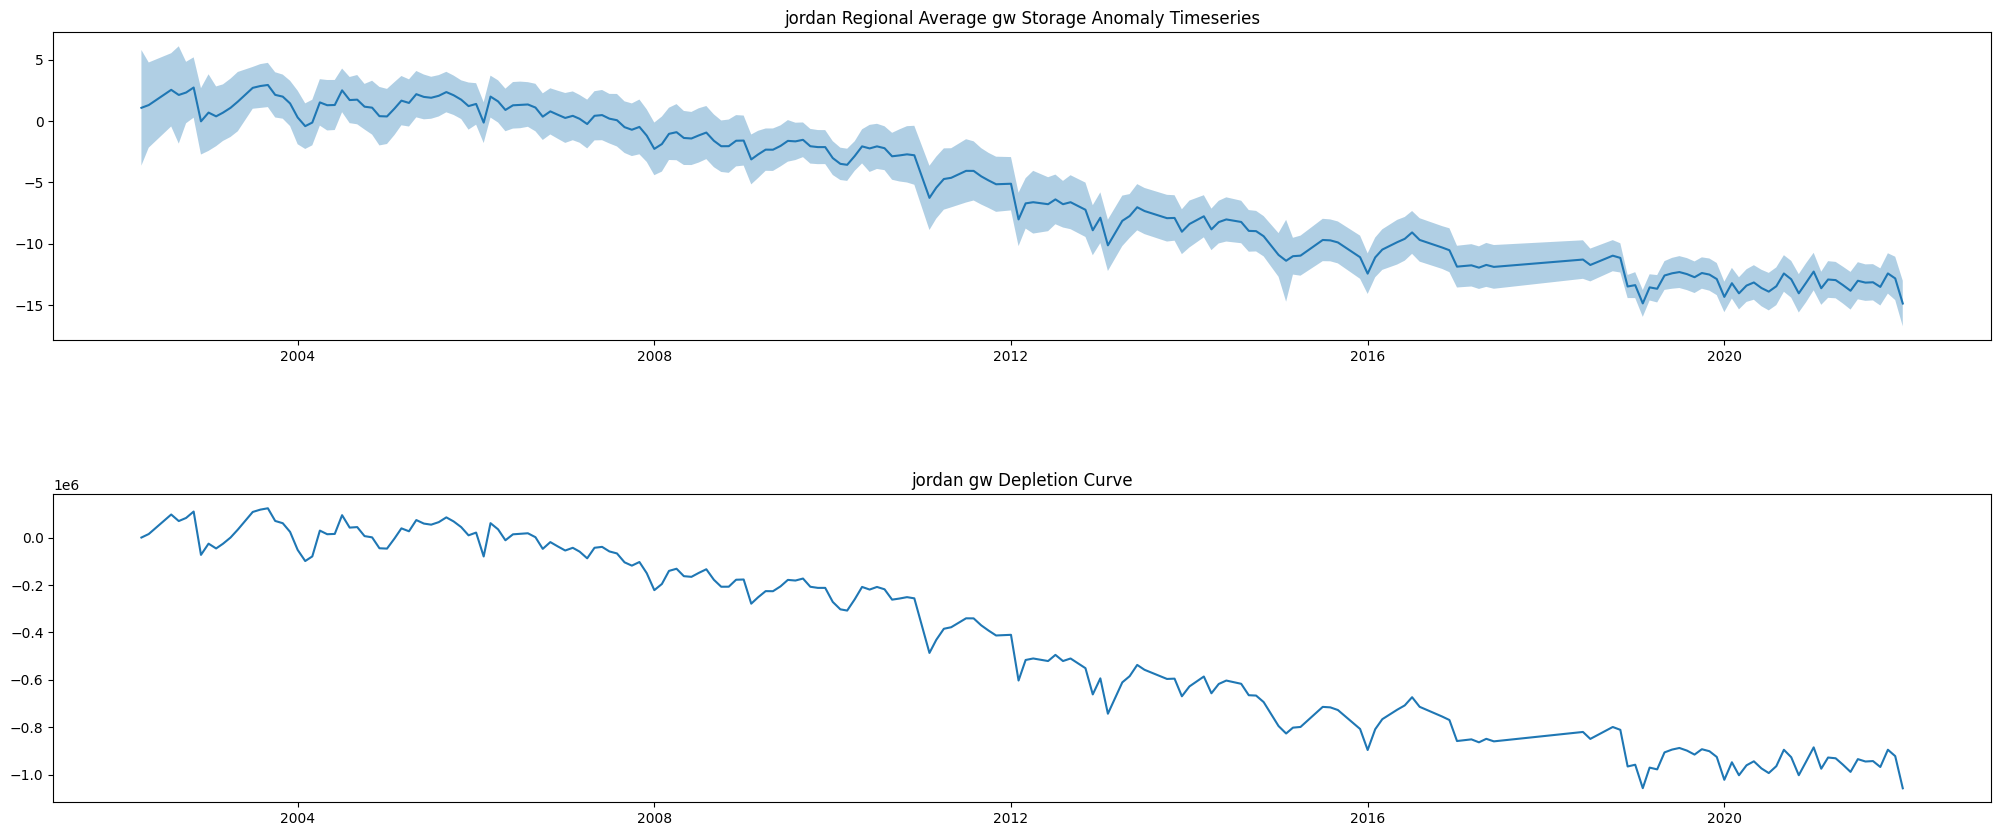

In [ ]:
#@markdown ### **Run this cell to plot Groundwater Anomaly Timeseries and Depletion Curve**
# Plotting two timeseries
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
ax[0].plot(gw_df.time, gw_df.value)
ax[0].fill_between(gw_df.time, gw_df.min_bar, gw_df.max_bar, alpha=0.35)
ax[0].set_title(region_name+ ' Regional Average ' + F4_Storage_Option+" Storage Anomaly Timeseries")
ax[1].plot(gw_df.time, gw_df.depletion)
ax[1].set_title(region_name+ ' ' +F4_Storage_Option+" Depletion Curve")
plt.subplots_adjust(wspace=0.4, hspace=0.5)

In [ ]:
#@markdown ### **Run this cell to create timeseries CSV**
#@markdown  You can download the CSV from the files panel on the left side of the window
#Export timeseries to CSV
region_ts.to_csv('RegionDataframe_'+region_name+".csv", index=False)

### Visualizing RegionZipfile


In [ ]:
#@title **Select which NetCDF you wish to view and run this cell to return it's characteristics**
NETCDF_abv = "gw" #@param ["gw", "sm", "sw", "swe", "tws", "canopy", "grace", "025sw", "025sm", "025gw", "025canopy", "025swe", "025tws"]
nc = xarray.open_dataset('/content/'+region_name+'/'+region_name+'_'+NETCDF_abv+'.nc')
lat,lon,time,var = nc.variables['lat'][:],nc.variables['lon'][:],nc.variables['time'][:], nc.variables['lwe_thickness'][:]
begin = numpy.datetime64(nc.coords['time'].values[0], 'D')
end = numpy.datetime64(nc.coords['time'].values[len(nc['time'][:])-1], 'D')
print('Begins on: ' + str(begin))
print('Ends on: ' + str(end))
print('')
print(NETCDF_abv+ ' min: ' +str(numpy.amin(var)))
print('')
print(NETCDF_abv+ ' max: ' +str(numpy.amax(var)))

Begins on: 2002-04-01
Ends on: 2022-01-01

gw min: <xarray.Variable ()>
array(-34.09225988)

gw max: <xarray.Variable ()>
array(6.42289173)


In [ ]:
#@title **Change Parameters to Customize your Images and GIF animation**
#@markdown Choose a start and date within the dataset range (our datasets are monthly so the exact day is not important):
startdate = "2008-04-01" #@param {type:"date"}
enddate = "2012-01-01" #@param {type:"date"}
#@markdown Cosmetic Options:
cmap_colorscheme = "Spectral" #@param ["jet", "viridis", "Spectral", "rainbow"] {allow-input: true}
frame_duration = 300 #@param {type:"slider", min:100, max:1000, step:50}
EsriBasemaps = "World_Topo_Map" #@param ["NatGeo_World_Map", "USA_Topo_Maps", "World_Imagery", "World_Physical_Map", "World_Shaded_Relief", "World_Street_Map", "World_Terrain_Base", "World_Topo_Map"]
Frame_Cushion = 1 #@param {type:"slider", min:0, max:15, step:0.5}

#Set up the time index for your GIF
starttime = numpy.datetime64(startdate, 'M')
endtime = numpy.datetime64(enddate, 'M')
startindex, endindex = -1, -1
for i in range(len(nc['time'][:])):
  check = numpy.datetime64(nc.coords['time'].values[i], 'M')
  if starttime < check and startindex == -1:
    startindex = i-1
  if endtime <= check and endindex == -1:
    endindex = i

In [ ]:
#@markdown ### **Run this cell to create individual timestamped images**
if path.exists('/content/'+region_name+NETCDF_abv+'_imgs') == False:
  os.mkdir('/content/'+region_name+NETCDF_abv+'_imgs')
#setting up the figure and map
plt.figure(figsize=(12,6))
lons,lats=numpy.meshgrid(lon,lat)
topbound = numpy.amax(lats)+0.5
bottombound = numpy.amin(lats)-0.5
rightbound= numpy.amax(lons)+0.5
leftbound = numpy.amin(lons)-0.5
m = Basemap(projection='cyl', llcrnrlon=leftbound-Frame_Cushion, llcrnrlat=bottombound-Frame_Cushion, urcrnrlon=rightbound+Frame_Cushion, urcrnrlat=topbound+Frame_Cushion, resolution='i', epsg=4326)
#m.bluemarble(alpha=0.8)
m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', service=EsriBasemaps, xpixels = 400, dpi = 69,verbose = True)
m.drawcoastlines(linewidth = 1.0,color='k')
m.drawstates(linewidth = 1.0,color='k')
m.drawcountries(linewidth = 1.0,color='k')
m.drawparallels(numpy.arange(bottombound-Frame_Cushion,topbound+Frame_Cushion,1),labels=[1,0,0,1], fontsize=8)
m.drawmeridians(numpy.arange(leftbound-Frame_Cushion,rightbound+Frame_Cushion,1),labels=[1,0,0,1], rotation=45, fontsize=8)

#creating the first image so that we can create the color scheme and labels
im = plt.imshow(var[startindex,:,:], cmap=cmap_colorscheme,extent=(leftbound, rightbound, topbound, bottombound),vmin=numpy.amin(var),vmax=numpy.amax(var))
plt.title(region_name+' ' +NETCDF_abv+' Anomaly '+str(nc.coords['time'].values[startindex])[:10], pad = 15), plt.xlabel('Longitude',labelpad=40), plt.ylabel('Latitude',labelpad=40)
cbar = plt.colorbar()
cbar.set_label("Liquid Water Equivalent (cm)", labelpad = 20)
plt.savefig(f"/content/{region_name+NETCDF_abv}_imgs/'{region_name+NETCDF_abv+str(nc.coords['time'].values[startindex])[:10]}.jpg")

#looping through the remaining images
for i in range(startindex+1,endindex+1):
  im = plt.imshow(var[i,:,:], cmap=cmap_colorscheme,extent=(leftbound, rightbound, topbound, bottombound),vmin=numpy.amin(var),vmax=numpy.amax(var))
  plt.title(region_name+' ' +NETCDF_abv+' Anomaly '+str(nc.coords['time'].values[i])[:10], pad = 15)
  plt.savefig(f"/content/{region_name+NETCDF_abv}_imgs/'{region_name+NETCDF_abv+str(nc.coords['time'].values[i])[:10]}.jpg")
plt.close()

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=34.0,28.0,40.0,34.0&bboxSR=4326&imageSR=4326&size=400,400&dpi=69&format=png32&transparent=true&f=image


In [ ]:
#@markdown ### **Run this cell to stitch images together into a GIF animation**
frames = []
imgs=glob.glob(f"/content/{region_name+NETCDF_abv}_imgs/*.jpg")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    frames[0].save(region_name+NETCDF_abv+'_animation.gif', format='GIF', append_images=frames[1:],save_all=True, duration = frame_duration, loop=0)